# Phase Curve of Solar System Objects
<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
Contact authors: Christina Williams and Yumi Choi<br>
Last verified to run: 2024-12-17 <br>
LSST Science Piplines version: Weekly 2024_50 <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

**Description:** Explore phase curves for DP0.3 solar system objects. 

**Skills:** Use the TAP service and ADQL to access the DP0.3 tables. Join information from multiple DP0.3 tables. Plot phase curves.

**LSST Data Products:** TAP tables dp03_catalogs_10yr.SSObject, dp03_catalogs_10yr.MPCORB, dp03_catalogs_10yr.DiaSource, dp03_catalogs_10yr.SSSource

**Packages:** lsst.rsp.get_tap_service

**Credit:**
Inspired by a jupyter notebook developed by Queen's University Belfast Planet Lab (including Brian Rogers, Niall McElroy, and Meg Schwamb). References: <a href="https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract">Muinonen et al. (2010)</a> and <a href="http://astronotes.co.uk/blog/2018/05/28/determining-the-h-g-parameters-of-atlas-asteroid-phase-curves.html">David Young's webpage.</a> Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:** Find DP0 documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook explores the properties of solar system bodies in the DP0.3 dataset by using the science example of constructing and exploring their phase curves. 

The DP0.3 catalogs contain both real and simulated solar system objects (including asteroids, near-Earth objects, Trojans, trans-Neptunian objects, comets). These objects change position between each Rubin image. In the DP0.3 catalogs, the intrinsic properties and orbital parameters are known, and are used to estimate what the measurements would be in a given image, and how they change between images. From these simulated observations, it is possible to reconstruct their intrinsic properties and orbital parameters in the same way as will be done using the real LSST data. An important way to characterize intrinsic properties of a solar system object is by measuring its "phase curve", which is the object brightness as a function of its "solar phase angle" (the angle made between the line of sight from the object to the Sun, and the line of sight from the object to Earth; see Figure 1.

                                            
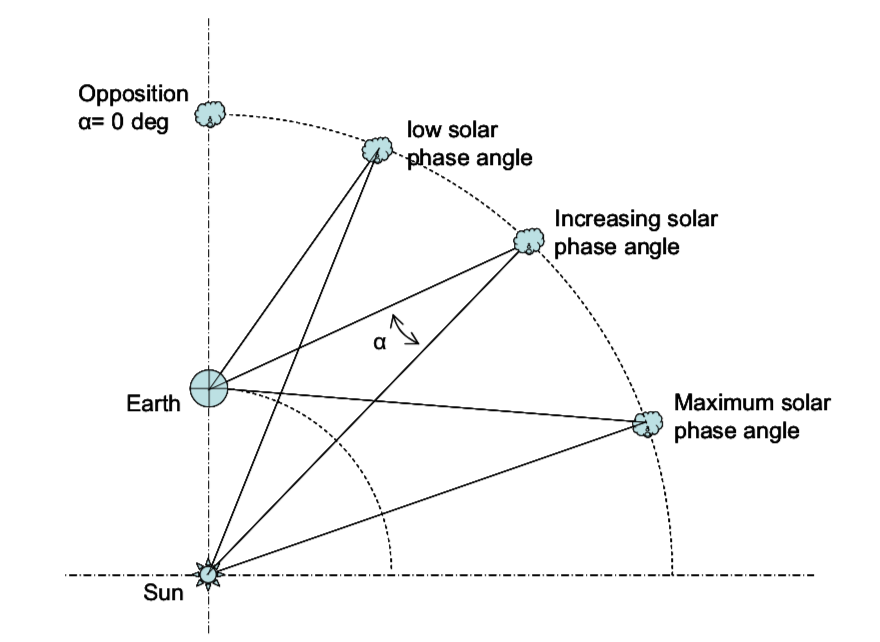


> **Figure 1:** Diagram showing the definition of phase angle $\alpha$, credit [Buchheim 2010](https://articles.adsabs.harvard.edu/pdf/2010SASS...29..101B)

In order to reveal the intrinsic properties of the asteroid (such as its surface properties and albedo, which helps determine its class of solar system body), we first must turn apparent magnitudes as a function of time (what is measured by LSST data) into "reduced magnitude", which takes into account the relative distances between the asteroid and the Sun/Earth (heliocentric/topocentric distances) at each observation. Reduced magnitude is normalized such that it is the brightness of an asteroid as if it is observed at 1 astronomical unit (au) from both the Sun and the Earth (i.e. unit topocentric and heliocentric distance). Note that rotation curves or complex geometry of solar system objects are not included in DP0.3 simulations. Thus, any changes over time in an object’s apparent magnitude are due only to changes in its distance and phase angle. Phase curves can be constructed for each filter.

Modeling the phase curve (reduced magnitude $H(α)$ as a function of phase angle $α$) enables measurement of the absolute magnitude, $H$, defined as the brightness at 0 phase angle. The functional form can depend on the data quality and type of object targeted. In this tutorial, we will mention three functional forms that are relevant for understanding the DP0.3 data products. These are the `HG_model`, `HG1G2_model`, and `HG12_model`. The `HG_model` is the simplest model (see [Bowell et al. 1989](https://ui.adsabs.harvard.edu/abs/1989aste.conf..524B/abstract)), and has the form:

$$H(α)=H−2.5log_{10}[(1−G)Φ_1(α)+GΦ_2(α)],$$

where $Φ_n$ are basis functions (which allow for one to model non-linearity in the data, but maintain linearity in the fitted parameters). $Φ_n$ are normalized to unity at α=0 deg. This model provides a best fit for the slope parameter $G$ (from which surface properties can then be derived) and the absolute magnitude $H$. The `HG_model` $G$ and $H$ values are stored in the `dp03_catalogs_10yr.MPCORB` table. 

To better accommodate various observational effects (e.g., photometric quality, incomplete phase angle sampling) the more sophisticated `HG1G2_model` (a linear three-parameter function) and its nonlinear two-parameter version `HG12_model` were developed (see [Muinonen et al. 2010](https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract)). The `HG1G2_model` has the form

$$H(α)=H−2.5log_{10}[G_1Φ_1(α)+G_2Φ_2(α) + (1-G_1-G_2)Φ_3(α)],$$

which now has three free parameters, $H$, $G_1$ and $G_2$. However, a third representation, the `HG12_model`, is generally very effective for deriving reliable values of absolute magnitude when the phase angle sampling is not optimal (e.g., poor phase angle coverage at a range of phase angle). Thus, the LSST data products will compute estimated parameters of the `HG12_model` and this will be the focus of this tutorial. The `HG12_model` expresses the $G_1$ and $G_2$ parameters as a piecewise linear function of a single parameter, $G_{12}$, 

for $G_{12}$ > 0.2
$$G_1 = 0.9529\times G_{12} + 0.02162$$
$$G_2 = -0.6125\times G_{12} + 0.5572$$
for $G_{12}$ < 0.2
$$G_1 = 0.7527\times G_{12} + 0.06164$$
$$G_2 = -0.9612\times G_{12} + 0.6270$$

This notebook will demonstrate how to plot the phase curve of solar system bodies using the DP0.3 simulated catalogs. Section 2 compares the phase curves for three different types of objects at different orbital radii from the Sun, and compares the data to the LSST pipeline measured phase curve parameters, `H`, and `G12`. Section 3 aggregates the phase curve fits for a number of solar system bodies in DP0.3 and shows how the quality of the fit depends on LSST observations (which additionally provides some insight into expectations for real LSST data).

### 1.1 Package Imports

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), and [scipy](https://scipy.org/) libraries are widely used Python libraries for plotting and scientific computing, and model fitting.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The [seaborn](https://seaborn.pydata.org/) package provides statistical data visualization with aesthetic and informative graphics.

The [sbpy](https://sbpy.org) package is an `Astropy` affiliated package for small-body planetary astronomy.

In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import seaborn as sns
from sbpy.photometry import HG12

from lsst.rsp import get_tap_service

### 1.2 Define Functions and Parameters

#### 1.2.1 Set up some plotting defaults

In [ ]:
plt.style.use('tableau-colorblind10')
params = {'axes.labelsize': 15,
          'font.size': 15,
          'legend.fontsize': 12}
plt.rcParams.update(params)

Set up colors and plot symbols corresponding to the $g,r,i,z$ bands since there are no $u$ and $y$ band data in the DP0.3 catalogs. These colors are the same as those used for $g,r,i,z$ bands in Dark Energy Survey (DES) publications, and are defined in <a href="https://github.com/DarkEnergySurvey/descolors">this github repository</a>.

In [ ]:
filts = ['g', 'r', 'i', 'z']
filter_colors = {'g': '#008060', 'r': '#ff4000', 'i': '#850000', 'z': '#6600cc'}

#### 1.2.2 Define functions

Define a function to convert a given perihelion distance (`q`) and eccentricity (`e`) to an orbital semi-major axis (`a`). Their relationship is defined by $q = a(1-e)$.

In [ ]:
def calc_semimajor_axis(q, e):
    """
    Given a perihelion distance and orbital eccentricity,
    calculate the semi-major axis of the orbit.

    Parameters
    ----------
    q: ndarray
        Distance at perihelion, in au.
    e: ndarray
        Orbital eccentricity.

    Returns
    -------
    a: ndarray
        Semi-major axis of the orbit, in au.
        q = a(1-e), so a = q/(1-e)
    """

    return q / (1.0 - e)

## 2. Plot the phase curves of asteroids in DP0.3 

### 2.1 Create the Rubin TAP Service Client

Get an instance of the TAP service, and assert that it exists.

In [ ]:
service = get_tap_service("ssotap")
assert service is not None

### 2.2 Querying the DP0.3 SSObject and MPCORB catalogs

To plot an object's phase curve, we will need its apparent magnitudes and uncertainties across a range of observation times. Additionally, we need the phase angles of the object at those observation times, topocentric ($d_t$) and heliocentric ($d_h$) distances.

To define those mock observations of solar system objects, the DP0.3 model uses the `HG_model` form of the phase curve to predict the observed parameters (apparent magnitude) for each object. These "truth" values are defined in the MPCORB table as `mpcH` (intrinsic absolute magnitude in $V$ band) and `mpcG` (intrinsic slope). For the purposes of DP0.3, the intrinsic slope, `mpcG`, for all objects have a constant value of 0.15.

In the SSObject table, the LSST data products contain the fitted phase curve parameters based on the mock observations using the `HG12_model` (i.e., the fitted absolute magnitude `H` and slope parameter `G12` based on mock observations in $griz$ bands). Note that the value of `G12` slope will differ from `G` owing to the difference in functional form (see Section 1.2). The explanation for the absence of $u$ and $y$ bands in DP0.3 catalogs can be found in the <a href="https://dp0-3.lsst.io/data-products-dp0-3/data-simulation-dp0-3.html">DP0.3 documentation</a>.

Limit the query to select sources with a large number of observations that likely have good phase curve fits (in the SSObject table, this is `numObs` > 100) and with perihelion distance of less than 50 au (in the MPCORB table, `q` < 50), and then further narrow down the sample to focus on Main Belt asteroids, Jupiter Trojans, and Trans-Neptunian Obects (TNOs) for this tutorial.  

Define the table returned by this query as "unique" since it contains the IDs of unique solar system objects. Each object has multiple individual observations in each filter in LSST. 

In [ ]:
nobs_thrh = '100'
q_thrh = '50'

Define query.

In [ ]:
query = """SELECT mpc.ssObjectId, mpc.e, mpc.q, mpc.mpcG, mpc.mpcH,
                sso.arc, sso.numObs,
                sso.g_H, sso.g_Herr, sso.g_G12, sso.g_G12err,
                sso.g_H_gG12_Cov, sso.g_Ndata, sso.r_H, sso.r_Herr,
                sso.r_G12, sso.r_G12err, sso.r_H_rG12_Cov, sso.r_Ndata,
                sso.i_H, sso.i_Herr, sso.i_G12, sso.i_G12err, sso.i_H_iG12_Cov,
                sso.i_Ndata, sso.z_H, sso.z_Herr, sso.z_G12, sso.z_G12err,
                sso.z_H_zG12_Cov, sso.z_Ndata
            FROM
                dp03_catalogs_10yr.MPCORB as mpc
                INNER JOIN dp03_catalogs_10yr.SSObject as sso
                ON mpc.ssObjectId = sso.ssObjectId
                WHERE sso.numObs > {} AND mpc.q < {} ORDER by sso.ssObjectId""".format(nobs_thrh, q_thrh)

Submit the asynchronous query and fetch the results into `uniqueObj`, as an `astropy` table.

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
uniqueObj = job.fetch_result().to_table()
assert job.phase == 'COMPLETED'

Show the contents of `uniqueObj`.

In [ ]:
uniqueObj

### 2.3 Identify Main Belt asteroids, Jupiter Trojans, and TNOs

First calculate the semi-major axis (`a`) of each object's orbit. Second, construct a Main Belt asteroid sample, a Jupiter Trojan sample, and a Trans-Neptunian Object (TNO) sample following the population definitions used by the JPL Horizons small body database query tool (https://ssd.jpl.nasa.gov/tools/sbdb_query.html): Main Belt asteroids (2.0 < `a` < 3.25 au and `q` > 1.666 au); Jupiter Trojans (4.6 < `a` < 5.5 au and `e` < 0.3), and finally TNOs which are at `a` > 30.1 au. We further limit our sample to the asteroids with `numObs` > 2000, to focus on objects with many individual observations to define its phase curve. (Note that the query for unique objects in Section 2.2 used a less-restrictive `numObs` > 100, which will used to explore the empirical properties that can influence phase curve fitting later in Section 3 and the followup tutorial notebook 04b).  

In [ ]:
a = calc_semimajor_axis(uniqueObj['q'], uniqueObj['e'])

main_belt = (a > 2.0) & (a < 3.2) & (uniqueObj['q'] > 1.666)
main_belt_2k = (uniqueObj['numObs'] > 2000) & main_belt

JT = (a > 4.6) & (a < 5.5) & (uniqueObj['e'] < 0.3)
JT_2k = (uniqueObj['numObs'] > 2000) & JT

TNO = (a > 30.1)
TNO_2k = (uniqueObj['numObs'] > 2000) & TNO

print('There are %d asteroids in this sample!' % len(a[main_belt_2k]))
print('There are %d Jupiter Trojans in this sample!' % len(a[JT_2k]))
print('There are %d TNOs in this sample!' % len(a[TNO_2k]))

all_2k = main_belt_2k + JT_2k + TNO_2k

Visualize the distributions of the semi-major axis `a` for the all unique objects in the 3 different populations.

In [ ]:
h = plt.hist(a[main_belt_2k], bins=25, range=(1, 7),
             label='Main Belt asteroids', alpha=.5)
h = plt.hist(a[JT_2k], bins=25, range=(1, 7),
             label='Jupiter Trojans', alpha=.5)
h = plt.hist(a[TNO_2k], bins=50, range=(1, 60), label='TNOs', alpha=.5)

plt.xlabel('Semi-major axis [au]')
plt.ylabel('Number')
plt.yscale('log')
plt.legend()
plt.show()

> **Figure 2:** Histograms of semi-major axis for Main Belt asteroids (blue), Jupiter Trojans (orange), and trans-Neptunian objects (TNOs; grey). Each population creates a distinct component, from small to large semi-major axis.

### 2.4 Identify individual mock observations of the solar system bodies in DP0.3 DiaSource and SSSource catalogs 

While there are unique solar system objects in the `SSObject` and `MPCORB` tables, these objects will be observed many times over the full LSST survey. Individual observations of each unique object in each filter are recorded in the `SSSource` and `diaSource` tables. Below, we query these tables to obtain all of the individual observed time series data (we call `indivObs`) for the solar system bodies that have >2000 observations as selected above.

Define query.

In [ ]:
query = """
SELECT
    dia.ssObjectId, dia.diaSourceId, dia.mag,
    dia.magErr, dia.band, dia.midPointMjdTai,
    sss.phaseAngle, sss.topocentricDist, sss.heliocentricDist
FROM
    dp03_catalogs_10yr.DiaSource as dia
INNER JOIN
    dp03_catalogs_10yr.SSSource as sss
ON
    dia.diaSourceId = sss.diaSourceId
WHERE
    dia.ssObjectId
    IN {}
ORDER by dia.ssObjectId
""".format(tuple(uniqueObj['ssObjectId'][all_2k]))

Submit asynchronous query, and fetch the results into astropy table `indivObs`.

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
indivObs = job.fetch_result().to_table()
assert job.phase == 'COMPLETED'

Show the results.

In [ ]:
indivObs

Confirm that the number of unique objects in `indivObs` is identical to that of the asteroids with > 2000 observations in `uniqueObj`, as they should be.

In [ ]:
assert len(uniqueObj[all_2k]) == len(np.unique(indivObs['ssObjectId']))

### 2.5 Plot the phase curve for a unique Main Belt asteroid

To plot the phase curve, it is necessary to first compute the reduced magnitude $H(\alpha)$ for each observation in each filter ($g,r,i,z$ for DP0.3), and add it as a column to the `indivObs` table of individual observations. The reduced magnitude $H(\alpha)$ as mentioned in Introduction is the normalized apparent magnitude of an asteroid as if it is observed at 1 au from both the Sun and the Earth as a function of phase angle $\alpha$, once accounting for the relative distances between the asteroid, and both Sun and Earth:

$$H(α) = m−5log_{10}(d_t\times\,d_h),$$

where $m$ is the apparent magnitude, and $d_t$ and $d_h$ are the topocentric and heliocentric distances of the object at the time of each observation. 

Note that the phase curves of solar system objects vary by observed filter, due to a combination of reflectivity of the surface and the intrinsic solar spectrum. For reference, to define the intrinsic absolute magnitude in DP0.3, the wavelength used to input the intrinsic absolute magnitude is in the $V$ band. Thus, one should not expect the absolute magnitude from any one filter to line up with the "truth" absolute magnitude, since none of the LSST filters include $V$ band. The conversion between each of the LSST filters and $V$ are documented for solar system bodies, and can be found in the <a href="https://github.com/lsst/dp0-3_lsst_io/blob/main/data-products-dp0-3/data-simulation-dp0-3.rst">DP0.3 documentation</a>.  

In [ ]:
thdist = indivObs['topocentricDist']*indivObs['heliocentricDist']
reduced_mag = indivObs['mag'] - 5.0*np.log10(thdist)

indivObs.add_column(reduced_mag, name='reducedMag')

The cell below will plot example phase curves in all available filters (in DP0.3) $g$,$r$,$i$,$z$ for a single object referenced by its ssObjectId, here called `sId`. (Explore different objects by changing the `iObj` index to retrieve different sources). Below, it is clear that the reduced magnitude and phase curve of the source are offset from each other in each filter, reflecting the variation in brightness of asteroids in different filters. 

It is possible to pick an integer number between 0 and `len(uniqueObj[main_belt_2k])-1` for `iObj` below to explore other objects.

The `HG12_model`-predicted phase curve is also overplotted to visualize the LSST pipeline phase curve fitting (dashed line). This demonstrates how absolute magnitude `H` is determined in the LSST data products.

In [ ]:
iObj = 1
sId = uniqueObj['ssObjectId'][main_belt_2k][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]
phases = np.linspace(0, 90, 100)


for i, ifilt in enumerate(filts):
    idx = tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5)

    # Plot HG12 model
    HG12_mag = HG12.evaluate(np.deg2rad(phases), 
                             uniqueObj[ifilt+'_H'][main_belt_2k][iObj], 
                             uniqueObj[ifilt+'_G12'][main_belt_2k][iObj])
    plt.plot(phases, HG12_mag, color=filter_colors[ifilt], linestyle='--',
             label='HG12 2-parameter model in %s' % ifilt)    


plt.xlim(tmp['phaseAngle'].min()-5, tmp['phaseAngle'].max()+5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)
plt.title('Main Belt Asteroid')
plt.show()

> **Figure 3:** The reduced magnitude as a function of phase angle in filters $griz$ (points) with a 2-parameter model fit (dashed lines).

The cell below compares the phase curve of one object from each of the three populations selected in Section 2.3: the Main Belt asteroids, with the more distant Jupiter Trojans and the TNOs. The color scheme is the same as the cell above. This cell must be executed after running the above cell first.

In [ ]:
plt.figure(figsize=(13, 4))

plt.subplot(131)
for i, ifilt in enumerate(filts):
    idx = tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5)

    # Plot HG12 model
    HG12_mag = HG12.evaluate(np.deg2rad(phases), 
                             uniqueObj[ifilt+'_H'][main_belt_2k][iObj],
                             uniqueObj[ifilt+'_G12'][main_belt_2k][iObj])
    plt.plot(phases, HG12_mag, color=filter_colors[ifilt], linestyle='--')


plt.xlim(tmp['phaseAngle'].min()-5, tmp['phaseAngle'].max()+5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.title('Main Belt Asteroid')

plt.subplot(132)

iObj = 2
sId = uniqueObj['ssObjectId'][JT_2k][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]

for i, ifilt in enumerate(filts):
    idx = tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5)

    # Plot HG12 model
    HG12_mag = HG12.evaluate(np.deg2rad(phases),
                             uniqueObj[ifilt+'_H'][JT_2k][iObj],
                             uniqueObj[ifilt+'_G12'][JT_2k][iObj])
    plt.plot(phases, HG12_mag, color=filter_colors[ifilt], linestyle='--')


plt.xlim(tmp['phaseAngle'].min()-5, tmp['phaseAngle'].max()+5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.title('Jupiter Trojans')

plt.subplot(133)
iObj = 3
sId = uniqueObj['ssObjectId'][TNO_2k][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]

for i, ifilt in enumerate(filts):
    idx = tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5)

plt.xlim(tmp['phaseAngle'].min()-.5, tmp['phaseAngle'].max()+.5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.title('TNO')

plt.tight_layout()
plt.show()

> **Figure 4:** Phase curves as in Figure 3, but the three panels represent objects from the three populations, from left to right: Main Belt asteroids, Jupiter Trojans, and TNOs.

Notice that the the phase coverage of objects at different semi-major axes are dramatically different. The most distant (>30.1 au) TNO will cover at most ~0-3 degrees in phase, and this is expected because they are too distant to have long phase angle coverage. Meanwhile, asteroids in the main belt will typically achieve between 0-30 degrees in terms of phase coverage. The LSST pipeline will only attempt to fit phase curves to things with more than 5 degrees of phase coverage, so the SSObject table does not include `H`, `G12` parameters for TNOs. Thus, TNOs do not have any models over-plotted. In these cases, it could be useful to independently model the phase curve using user-defined functions (e.g. for TNOs, a linear fit can be sufficient).

### 2.6 Explore phase curve fit uncertainty in each filter

For one of the Main Belt asteroids with > 2000 observations, the plot below compares the $g$- and $z$-bands to demonstrate fit uncertainty between two filters that produce different reduced magnitude quality (mostly due to difference in brightness and therefore flux uncertainties between the filters). The cell also computes the model phase curve for a given set of the best-fit phase curve parameters for the `HG12_model` stored in `SSObject` table, which is called `HG12_mag_sso`. The plot shows the uncertainty in the model parameters represented by the shaded regions. Choosing fainter or less well-sampled SSObjects increases the error region.


In [ ]:
iObj = 3
sId = uniqueObj['ssObjectId'][main_belt_2k][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]

for ifilt in ['g', 'z']:
    idx = tmp['band'] == ifilt
    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='o',
                 color=filter_colors[ifilt], label=ifilt, zorder=10)

    HG12_mag_sso = HG12.evaluate(np.deg2rad(phases),
                                 uniqueObj[ifilt+'_H'][main_belt_2k][iObj],
                                 uniqueObj[ifilt+'_G12'][main_belt_2k][iObj])
    plt.plot(phases, HG12_mag_sso, '--', alpha=0.3, color=filter_colors[ifilt])

    # Compute min/max values in reduced mag at each phase angle
    p1 = HG12.evaluate(np.deg2rad(phases),
                       uniqueObj[ifilt+'_H'][main_belt_2k][iObj] + 3*uniqueObj[ifilt+'_Herr'][main_belt_2k][iObj],
                       uniqueObj[ifilt+'_G12'][main_belt_2k][iObj] + 3*uniqueObj[ifilt+'_G12err'][main_belt_2k][iObj])

    p2 = HG12.evaluate(np.deg2rad(phases), 
                       uniqueObj[ifilt+'_H'][main_belt_2k][iObj] - 3*uniqueObj[ifilt+'_Herr'][main_belt_2k][iObj],
                       uniqueObj[ifilt+'_G12'][main_belt_2k][iObj] + 3*uniqueObj[ifilt+'_G12err'][main_belt_2k][iObj])

    p3 = HG12.evaluate(np.deg2rad(phases),
                       uniqueObj[ifilt+'_H'][main_belt_2k][iObj] + 3*uniqueObj[ifilt+'_Herr'][main_belt_2k][iObj],
                       uniqueObj[ifilt+'_G12'][main_belt_2k][iObj] - 3*uniqueObj[ifilt+'_G12err'][main_belt_2k][iObj])

    p4 = HG12.evaluate(np.deg2rad(phases),
                       uniqueObj[ifilt+'_H'][main_belt_2k][iObj] - 3*uniqueObj[ifilt+'_Herr'][main_belt_2k][iObj],
                       uniqueObj[ifilt+'_G12'][main_belt_2k][iObj] - 3*uniqueObj[ifilt+'_G12err'][main_belt_2k][iObj])

    HG_magHigh = np.maximum(np.maximum(p1, p2), np.maximum(p3, p4))
    HG_magLow = np.minimum(np.minimum(p1, p2), np.minimum(p3, p4))

    plt.fill_between(phases, HG_magLow, HG_magHigh, alpha=0.3, color=filter_colors[ifilt])

plt.xlim(tmp['phaseAngle'].min()-5, tmp['phaseAngle'].max()+5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('ssObjectId = %d' % sId)
plt.show()

> **Figure 5:** The phase curve fit (similar to Figure 3) for a single `SSObject` in filters $g$ (green) and $z$ (purple)

# 3. Exploring phase curve data products from the DP0.3 SSObject and MPCORB catalogs 


### 3.1 Distribution of H and G12 parameters in observed filters

This section explores the distribution of typical values of the `G12` slope parameter as a function of absolute magnitudes for Main Belt asteroids and Jupiter Trojans. Due to small phase angle coverage, nearly all of TNOs do not have measured phase curve parameters. Remember that the input (truth) `G` value using the `HG_model` that was used to generate the DP0.3 simulated object's observed properties was fixed across the population to a constant value of `G`=0.15. The DP0.3 automated phase curve fitting (which uses `HG12_model`) produces a nearly constant value for `G12` with a relatively small spread at bright magnitudes, and the scatter in measured `G12` starts to deviate more substantially at fainter magnitudes where its likely harder to recover the intrinsic value.

> **Warnings:** the following cell might produce `RuntimeWarning` messages about invalid values which can be ignored. They are due to taking the log of the occasional negative or NaN value in the catalog. Those points will not show in the plot.

In [ ]:
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, wspace=0.1, hspace=0.2)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.ravel()


for i, ifilt in enumerate(filts):
    sns.histplot(x=uniqueObj[ifilt+'_H'], y=uniqueObj[ifilt+'_G12'],
                 bins=100, log_scale=(False, True), ax=axs[i])
    axs[i].scatter(uniqueObj[ifilt+'_H'][main_belt],
                   uniqueObj[ifilt+'_G12'][main_belt],
                   s=3, c='m', alpha=0.3, label='Main Belt asteroids')
    axs[i].scatter(uniqueObj[ifilt+'_H'][JT],
                   uniqueObj[ifilt+'_G12'][JT],
                   s=3, c='k', alpha=0.1, label='Jupiter Trojans')
    axs[i].text(10, 5, ifilt+'-band')
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)

axs[0].legend(loc=3, fontsize=10)
plt.xlim(9, 25)
plt.ylim(1e-2, 1e1)

fig.supxlabel('Absolute magnitude, H [mag]')
fig.supylabel('Slope parameter, G12')
print(len(uniqueObj), len(uniqueObj[main_belt_2k]),
      len(uniqueObj[JT_2k]))
plt.show()

> **Figure 6:** The slope of the phase curve fit as a function of absolute H magnitude for Main Belt asteroids (purple) and Jupiter Trojans (black) in four filters, from upper left to lower right: $griz$. The underlying blue squares show the two-dimensional distribution of slope and magnitude for all objects.

### 3.2 Phase curve fit uncertainty vs. apparent brightness of the Main Belt asteroids

This section compares the typical apparent magnitude uncertainties per filter to see how that impacts the fit. First, compute the median apparent magnitude (i.e. as observed) and its median uncertainty in the $r$-band in this example. This enables plotting phase curve parameters vs. median apparent magnitude and its median uncertainty to see how these observational characteristics impact the resulting modeling. One can see in the plot that as objects get fainter and the median apparent magnitude uncertainty increases, so does the uncertainty in the fitted parameters of the phase curve. 

In [ ]:
mag_med = []
magSigma_med = []
ifilt = 'r'

for iobj in uniqueObj['ssObjectId'][main_belt_2k]:
    idx = indivObs['ssObjectId'] == iobj
    tmp = indivObs[idx]
    idx_filt = tmp['band'] == ifilt

    mag_med.append(np.ma.median(tmp['mag'][idx_filt]))
    magSigma_med.append(np.ma.median(tmp['magErr'][idx_filt]))

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(mag_med, uniqueObj[ifilt+'_Herr'][main_belt_2k], '.', alpha=.5,
         label=ifilt+'-band H parameter')
plt.plot(mag_med, uniqueObj[ifilt+'_G12err'][main_belt_2k], '.', alpha=.5,
         label=ifilt+'-band G12 parameter')
plt.ylabel('Uncertainty in phase curve fit')
plt.xlabel('Median apparent mag')
plt.legend()

plt.subplot(122)
plt.plot(magSigma_med, uniqueObj[ifilt+'_Herr'][main_belt_2k],
         '.', alpha=.5)
plt.plot(magSigma_med, uniqueObj[ifilt+'_G12err'][main_belt_2k],
         '.', alpha=.5)
plt.ylabel('Uncertainty in phase curve fit')
plt.xlabel('Median uncertainty in apparent mag')

plt.tight_layout()
plt.show()

> **Figure 7:** The uncertainty in the phase curve fit parameters, absolute H magnitude (blue) and slope (blue), as a function of the object's apparent magnitude (left) and uncertainty in apparent magnitude (right). These plots show how the errors in the phase curve fits are related to object brightness.

### 3.3 Phase curve fit uncertainty vs. total number of LSST observations and perihelion distance

This section explores the impact of the total number of observations for a given source (`numObs`) and the perihelion distance (`q`) on the quality of phase curve fitting in $i$-band as an example. In the left columns, it is clear that the model uncertainties decrease with number of observations of each source. So as LSST accumulates data over time, precision in the phase curve modeling will improve. The right columns show that uncertainties in the phase curve parameters modestly increase for objects with larger perihelion distances. 

In [ ]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, wspace=0, hspace=0.7)
axs = gs.subplots(sharey=True)
ifilt = 'i'

sns.histplot(x=uniqueObj['numObs'], y=uniqueObj[ifilt+'_Herr'], bins=100,
             log_scale=(False, True), ax=axs[0, 0])
axs[0, 0].set_xlabel('Number of LSST observations')
axs[0, 0].set_ylabel(r'$\Delta$H in %s band' % ifilt)
plt.ylim(1e-4, 3e1)

sns.histplot(x=uniqueObj['q'], y=uniqueObj[ifilt+'_Herr'],
             bins=100, ax=axs[0, 1])
axs[0, 1].set_xlabel('perihelion distance [au]')

sns.histplot(x=uniqueObj['numObs'], y=uniqueObj[ifilt+'_G12err'],
             bins=100, log_scale=(False, True), ax=axs[1, 0])
axs[1, 0].set_xlabel('Number of LSST observations')
axs[1, 0].set_ylabel(r'$\Delta$G12 in %s band' % ifilt)

sns.histplot(x=uniqueObj['q'], y=uniqueObj[ifilt+'_G12err'],
             bins=100, ax=axs[1, 1])
axs[1, 1].set_xlabel('perihelion distance [au]')
plt.show()

> **Figure 8:** The uncertainty in the phase curve fit parameters, absolute H magnitude (top) and slope (bottom), as a function of the number of LSST observations (detections) of the object (left) and the object's distance from the Sun (right). These plots show how the errors in the phase curve fits are related to the object's detecability and distance.

### 3.4 Number of datapoints used for phase curve fitting per band

The above plots compare `numObs` (total in all bands) with model fits (per band) which may not be the ideal metric since the quality of phase curves can vary quite a bit between filters. Instead, one can look at the number of datapoints included in the phase curve modeling on a per filter basis (i.e. `rNdata` for the r-band in the `SSObject` table). The next plot looks at the distribution of the number of observations in each filter used to model the phase curve per filter. One can see that generally, $r$- and $i$-bands produce the most data points for recovering phase curves, while $g$-band produces less and $z$-band produces the fewest. Phase curves measured in $r$- and $i$-bands will thus be better sampled. 

Thus in the second panel, one can see that poorer sampling drives higher uncertainty in `H` using $z$-band instead of $r$-band for solar system objects. 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i, ifilt in enumerate(filts):
    axs[0].hist(uniqueObj[ifilt+'_Ndata'], bins=100, range=(0, 1300),
                histtype='step', color=filter_colors[ifilt], label=ifilt+'-band')

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_xlabel('Number of data points per filter')
axs[0].set_ylabel('Number of sources')

sns.histplot(x=uniqueObj['r_Herr'], y=uniqueObj['z_Herr'],
             bins=100, log_scale=(True, True), color='b', ax=axs[1], alpha=0.7)

one2one = np.arange(1e-4, 1000, .1)
axs[1].plot(one2one, one2one, '--')
axs[1].set_ylim(1e-4, 1e2)
axs[1].set_xlim(1e-4, 1e2)
axs[1].set_ylabel(r'$\Delta$H using z-band')
axs[1].set_xlabel(r'$\Delta$H using r-band')

plt.tight_layout()
plt.show()

> **Figure 9:** At left, a histogram of the number of solar system objects ($y$-axis) with a given number of detections ($x$-axis) per filter (legend). This plot shows that generally, objects have more detections in the $r$ and $i$ filters. From this it can be inferred that phase curve fits in $r$ and $i$ will be more accurate. At right, the error in the absolute H magnitudes derived from phase curve fits in the $z$ band ($y$-axis) versus the $i$ band ($x$-axis), showing that errors are larger from $z$ band.

## 4. Excercises for the learner

1. Try out the more advanced companion tutorial notebook 04b on explicitly modeling phase curves and comparing with the `HG12` model parameters stored in the DP0.3.